# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [24]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
# import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image
from keras.datasets import mnist

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.5.0


# Task 2: Importing and Plotting the Data

In [25]:
(x_train, y_train), (x_test, y_test)= mnist.load_data()

x = np.concatenate([x_train, x_test], axis=0)

In [28]:
#mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [30]:
discriminator  =  Sequential([
    
    Conv2D(64, 3, strides=2, input_shape=(28,28,1) ),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1 = 0.5)

discriminator.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 256)        

# Task 4: Generator

In [31]:
# Going in the opposite directionsa

generator = Sequential([
    
    Dense(256, activation='relu', input_shape=(1,)),
    Reshape((1,1,256)),
    
    #Convnet for increasing the row and col dimesnion
    Conv2DTranspose(256, 5 , activation = 'relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128, 5 , activation = 'relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64, 5 ,strides = 2, activation = 'relu'),
    BatchNormalization(),
    
    Conv2DTranspose(32, 5 , activation = 'relu'),
    BatchNormalization(),
    
    Conv2DTranspose(1, 4 , activation='sigmoid')
    
])

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

<IPython.core.display.Javascript object>


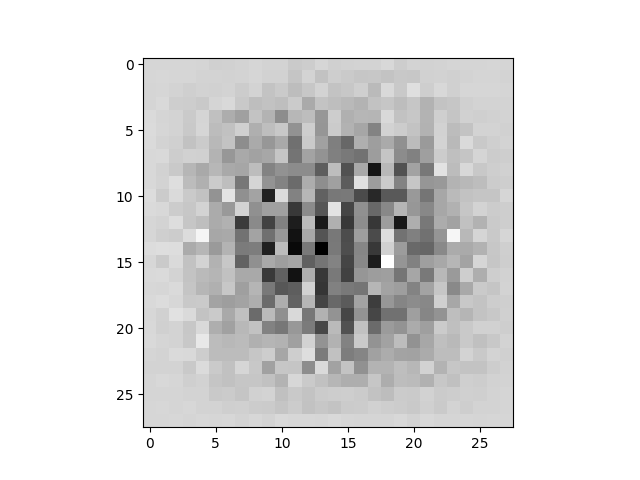

In [32]:
noise = np.random.randn(1,1)
gen_image = generator.predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28,28)), cmap='binary')

# Task 5: Generative Adversarial Network (GAN)

In [33]:
input_layer = tf.keras.layers.Input(shape=(1,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

#By defualt we will set the discriminator to non trainable

discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [34]:
epochs = 25
batch_size = 128

steps_per_epochs = int(2*x.shape[0]/batch_size)

print('Steps per epochs=',steps_per_epochs)

Steps per epochs= 1093


In [ ]:
dp = tfutils.plotting.DynamicPlot(plt,5,5, (8,8)) # to ceck the generator outpput after each epoch

for e in range(0, epochs):
    dp.start_of_epoch(e)
    for step in range(0, steps_per_epochs):
        true_examples = x[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0],28,28,1))
        
        noise = np.random.randn(int(batch_size/2),1)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis=0)
        y_batch = np.array([0]*int(batch_size/2) + [1]*int(batch_size/2))
        
        indices = np.random.choice(range(batch_size), batch_size, replace = False)
        
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True 
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
        _, acc = discriminator.evaluate(x_batch, y_batch, verbose= False)
        
    noise = np.random.randn(1,1)
    gen_image = generator.predict(noise)[0]
    gen_image = np.reshape(gen_image, (28,28))
    dp.end_of_epoch(gen_image, 'binary','DiscASCC:{:.2f}'.format(acc),'GANLoss:{:.2f}'.format(loss))